# qPCA

In [1]:
import setup
from circuits import * 
import qiskit

import sympy as sp

from qiskit.opflow import MatrixOp, CircuitOp

from qiskit.quantum_info.states.densitymatrix import DensityMatrix
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import random_density_matrix

In [2]:
def printmat(x, precision=4, max_size=7):
    try:
        return qiskit.visualization.array_to_latex(x, precision=precision, prefix='', source=False, max_size=max_size)
    except TypeError:
        return print(x)

# Partial Swap Operator

### Initialising $\sigma$ and $\rho^{\otimes n}$

In [3815]:
m = 3
D = np.random.rand(m,4)

# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in D])
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = (1/m)*(np.matmul(X,X.T))
rho = DensityMatrix(Q)
cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 

evals, evecs = np.linalg.eig(Q)

In [3816]:
# Ansatz
#sigma = rho
sigma = DensityMatrix(1/2*np.matmul(np.array([[1,0,0,1]]).T, np.array([[1,0,0,1]])))
sigma.is_valid()

True

### Showing $e^{-i\rho \delta t} \approx Tr_{\rho}[e^{-iS \delta t}]$

In [3817]:
sigma = random_density_matrix(4)

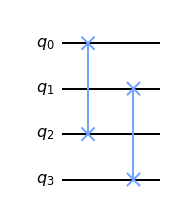

In [3818]:
qc = QuantumCircuit(4)
qc.swap([0,1],[2,3]);
qc.draw('mpl')

In [3819]:
t = 2*np.pi/2
N = 1000
dt = t/N

In [3820]:
# np.exp(SWAP*dt)
swap_4 = Operator(qc)

def exp_swap_4(x):
    return Operator(MatrixOp(x*swap_4).exp_i())

# Evolve sigma via Trotter
sigma_ = sigma.copy()
for i in range(N):
    sigma_ = DensityMatrix(partial_trace((rho ^ sigma_).evolve(exp_swap_4(dt)), [2,3])) # Leftmost is lowest, except in partial trace where labeling is important

In [3821]:
# np.exp(SWAP*t*rho)
exp_rho = Operator(MatrixOp(t*Q).exp_i())

In [3822]:
printmat(sigma_.data - sigma.evolve(exp_rho).data)

<IPython.core.display.Latex object>

# Partial Swap Implementation

## Two qubits

In [2130]:
from qiskit.circuit import QuantumCircuit, Parameter

In [2131]:
w = Parameter("w")

In [2134]:
qc = QuantumCircuit(2)

qc.swap([0],[1]);

qc.draw('mpl')

In [2135]:
t = 1
N = 10
dt = t/N

In [2136]:
swap_2 = Operator(qc)
exp_swap_control_2 = Operator(Operator(MatrixOp(dt*swap_2).exp_i()).to_instruction().control(1))

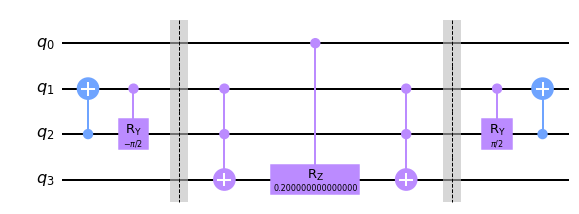

In [2381]:
def make_exp_swap_control_2(par):
    qc2 = QuantumCircuit(4)

    qc2.cnot(2,1)
    qc2.cry(-np.pi/2, control_qubit=1, target_qubit=2)

    qc2.barrier()

    qc2.toffoli(1, 2, 3)


    qc2.crz(2*par, 0,3)

    qc2.toffoli(1, 2, 3)

    qc2.barrier()

    qc2.cry(np.pi/2, control_qubit=1, target_qubit=2)

    qc2.cnot(2,1)
    
    return qc2

qc2.draw('mpl')

In [2138]:
qc2 = make_exp_swap_control_2(w).assign_parameters({w:dt})

In [2139]:
from qiskit.opflow import (StateFn, Zero, One, Plus, Minus, H,
                           DictStateFn, VectorStateFn, CircuitStateFn, OperatorStateFn)

In [2140]:
x1 = (MatrixOp(exp_swap_control_2) @ (Plus ^ Plus ^ Plus)).eval().to_density_matrix()

In [2141]:
x2 = partial_trace((MatrixOp(Operator(qc2)) @ (Zero ^ Plus ^ Plus ^ Plus)).eval().to_density_matrix(), [3])

In [2142]:
printmat(x2.data-x1.data)

<IPython.core.display.Latex object>

In [2143]:
rho_i = DensityMatrix(np.diag([1,0]))^random_density_matrix(2**3)

In [2144]:
printmat(partial_trace(rho_i,[3]).evolve(exp_swap_control_2).data - partial_trace(rho_i.evolve(Operator(qc2)),[3]).data, max_size=10)

<IPython.core.display.Latex object>

## Four qubits

In [2261]:
qc = QuantumCircuit(4)
qc.swap([0,1],[2,3]);

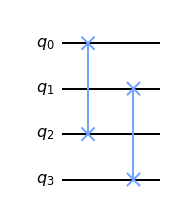

In [ ]:
qc.draw('mpl')

In [ ]:
swap_4 = Operator(qc)
exp_swap_control_4 = Operator(Operator(MatrixOp(dt*swap_4).exp_i()).to_instruction().control(1))

In [ ]:
qc2 = QuantumCircuit(6)

qc2.cnot(2,0)
qc2.cry(-np.pi/2, control_qubit=0, target_qubit=2)

qc2.barrier()

qc2.cnot(3,1)
qc2.cry(-np.pi/2, control_qubit=1, target_qubit=3)

qc2.barrier()

qc2.toffoli(0, 2, 4)
qc2.toffoli(1, 3, 4)

qc2.crz(2*dt, 5,4)

qc2.toffoli(1, 3, 4)
qc2.toffoli(0, 2, 4)

qc2.barrier()

qc2.cry(np.pi/2, control_qubit=1, target_qubit=3)
qc2.cnot(3,1)

qc2.barrier()

qc2.cry(np.pi/2, control_qubit=0, target_qubit=2)
qc2.cnot(2,0)

In [ ]:
qc3 = QuantumCircuit(6)
qc3 = qc3.compose(qc2, [1,2,3,4,5,0])

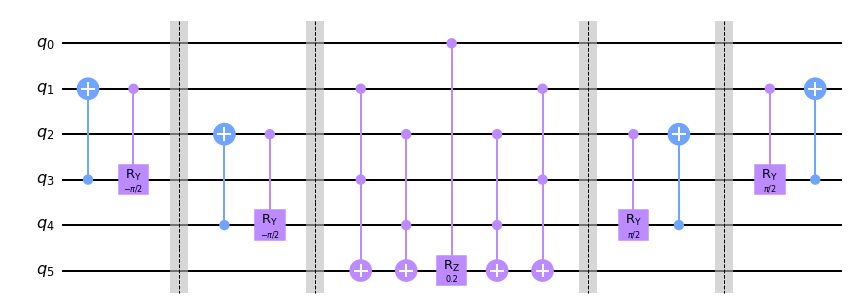

In [ ]:
qc3.draw('mpl')

In [ ]:
rho_i = DensityMatrix(np.diag([1,0]))^random_density_matrix(2**5)

In [ ]:
# Simulated
rho_f_simul = partial_trace(rho_i, [5]).evolve(exp_swap_control_4)

# Circuit
rho_f_qc = partial_trace(rho_i.evolve(Operator(qc3)), [5])

In [ ]:
printmat(rho_f_simul.data - rho_f_qc.data)

<IPython.core.display.Latex object>

## Symbolic Representation

In [3173]:
import sympy as sp

In [828]:
def kron(*m):
    if(len(m)==1):
        return m[0]
    return sp.Matrix(np.kron(m[0], kron(*m[1:])))

In [3174]:
def mycontrol(x, order=0):
    if(order):
        return sp.Matrix(np.kron(np.diag([0,1]),x)) + sp.Matrix(np.kron(np.diag([1,0]), np.eye(x.shape[0])))
    return sp.Matrix(np.kron(x, np.diag([0,1]))) + sp.Matrix(np.kron(np.eye(x.shape[0]), np.diag([1,0])))
    

In [915]:
def rz(x):
    return sp.simplify((-sp.I/2*x*Z).exp())

def ry(x):
    return sp.simplify((-sp.I/2*x*Y).exp())

def cry(x):
    return mycontrol(ry(x))

In [674]:
a, b, t =  sp.symbols('a b t') 

In [702]:
I = np.eye(2)

In [714]:
Y = sp.Matrix([[0, -sp.I], [sp.I, 0]])

In [740]:
Z = sp.Matrix([[1, 0], [0, -1]])

In [826]:
myswap = sp.Matrix(np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]))

In [847]:
myswap_exp = sp.simplify((-sp.I/2*t*myswap).exp())
myswap_exp

Matrix([
[exp(-I*t/2),           0,           0,           0],
[          0,    cos(t/2), -I*sin(t/2),           0],
[          0, -I*sin(t/2),    cos(t/2),           0],
[          0,           0,           0, exp(-I*t/2)]])

In [848]:
cnot = mycontrol(X)

In [849]:
cnot

Matrix([
[1.0,   0,   0,   0],
[  0,   0,   0, 1.0],
[  0,   0, 1.0,   0],
[  0, 1.0,   0,   0]])

In [850]:
toffoli = mycontrol(cnot)

In [851]:
toffoli

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0]])

In [923]:
fh = (kron(I, mycontrol(X, order=1), I)*kron(I, cry(-a), I))*kron(toffoli, I)*sp.Matrix(mycontrol(kron(rz(t), I, I)))

In [924]:
matrix = ((fh * kron(toffoli, I) * kron(I, cry(a), I) * (kron(I, mycontrol(X, order=1), I))).subs({a:np.pi/2}))

In [925]:
finalansatz = sp.nsimplify(matrix).rewrite(sp.cos).trigsimp()

### Sympy circuit

In [926]:
finalansatz[:8,:8].subs({t:2*dt})

Matrix([
[1,                                        0, 0,                    0, 0,                    0, 0,                                        0],
[0, 0.995004165278026 - 0.0998334166468282*I, 0,                    0, 0,                    0, 0,                                        0],
[0,                                        0, 1,                    0, 0,                    0, 0,                                        0],
[0,                                        0, 0,    0.995004165278026, 0, 0.0998334166468282*I, 0,                                        0],
[0,                                        0, 0,                    0, 1,                    0, 0,                                        0],
[0,                                        0, 0, 0.0998334166468282*I, 0,    0.995004165278026, 0,                                        0],
[0,                                        0, 0,                    0, 0,                    0, 1,                                        0

### Qiskit Circuit

In [927]:
printmat(Operator(qc2).data[:8,:8], max_size=16)

<IPython.core.display.Latex object>

### Sympy math

In [928]:
sp.simplify(mycontrol(myswap_exp).subs({t:2*dt}))

Matrix([
[1.0,                                        0,   0,                     0,   0,                     0,   0,                                        0],
[  0, 0.995004165278026 - 0.0998334166468282*I,   0,                     0,   0,                     0,   0,                                        0],
[  0,                                        0, 1.0,                     0,   0,                     0,   0,                                        0],
[  0,                                        0,   0,     0.995004165278026,   0, -0.0998334166468282*I,   0,                                        0],
[  0,                                        0,   0,                     0, 1.0,                     0,   0,                                        0],
[  0,                                        0,   0, -0.0998334166468282*I,   0,     0.995004165278026,   0,                                        0],
[  0,                                        0,   0,                     0,   0

### Qiskit Math

In [929]:
printmat(exp_swap_control_2, max_size=16)

<IPython.core.display.Latex object>

## Showing $Tr_{\rho^{\otimes N}}\big[\prod_{j=1}^N(\text{C-}e^{-iS_j\frac{t}{N}})\big] \approx \text{C-}e^{-i\rho t}$

In [2556]:
t = 1
N = 1000
dt = t/N

In [2557]:
# X \in R^3x4, 4-D data arranged rowwise 
D = np.array([[0.32241437, 0.04200095],
       [0.32591982, 0.04014517],
       [0.17208166, 0.61868603]])
# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in D])

# Columns
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = 1/3*np.matmul(X,X.T)
rho = DensityMatrix(Q)

In [2558]:
cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 

evals, evecs = np.linalg.eig(rho.data)

sigma = DensityMatrix(np.outer(evecs[1], evecs[1]))

evals[1]

(0.2529181977115852+0j)

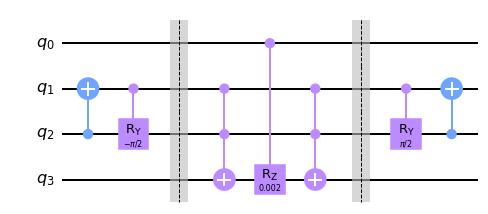

In [2559]:
make_exp_swap_control_2(dt).draw('mpl')

In [2560]:
# Evolve sigma via Trotter
sigma_i = sigma.copy() ^ random_density_matrix(2)
sigma_ = sigma_i.copy()
for i in range(N):
    for x in cols:
        sigma_ = DensityMatrix(partial_trace((DensityMatrix(np.diag([1,0])) ^ x ^ sigma_).evolve(Operator(make_exp_swap_control_2(dt/len(cols)))), [2,3])) # Leftmost is lowest, except in partial trace where labeling is important

In [2561]:
exp_rho = Operator(Operator(MatrixOp(t*Q).exp_i()).to_instruction().control(1))

In [2562]:
printmat(sigma_.data - sigma_i.evolve(exp_rho).data)

<IPython.core.display.Latex object>

# QPE

## Helper functions

In [2392]:
def c_es2(par):
    qc2 = QuantumCircuit(4)

    qc2.cnot(2,1)
    qc2.cry(-np.pi/2, control_qubit=1, target_qubit=2)

    qc2.barrier()

    qc2.toffoli(1, 2, 3)
    qc2.crz(2*par, 0,3)
    qc2.toffoli(1, 2, 3)

    qc2.barrier()

    qc2.cry(np.pi/2, control_qubit=1, target_qubit=2)
    qc2.cnot(2,1)
    
    return qc2

def qc_swap2():
    qc = QuantumCircuit(2)
    qc.swap([0],[1])
    return qc

## Implementation

In [66]:
from qiskit.opflow import I, X, Y, Z

from qiskit.circuit.library import QFT

In [67]:
def exp_rho(x, Q):
    return Operator(Operator(MatrixOp(x*Q).exp_i()).to_instruction().control(1))

In [68]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [70]:
m = 3
D = np.random.rand(m,2)

In [69]:
# 0.25
D = np.array([[0.32241437, 0.04200095],
       [0.32591982, 0.04014517],
       [0.17208166, 0.61868603]])

In [77]:
# well partitioned
D = np.array([[0.68392582, 0.11945512],
       [0.03946855, 0.90996401],
       [0.80280525, 0.216806  ]])

In [78]:
# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in D])
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = (1/m)*(np.matmul(X,X.T))
rho = DensityMatrix(Q)
cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 

evals, evecs = np.linalg.eig(Q)

In [79]:
evaldp = 5
eval_reg = QuantumRegister(evaldp, 'eval')
rho_reg = QuantumRegister(1, 'rho')
anc_reg = QuantumRegister(2, 'ancilla')

# 1/3 of QPE: Initialisation and Hadamards 
main_1 = QuantumCircuit(eval_reg, rho_reg)
main_1.h(range(0,evaldp));

#DensityMatrix(np.outer(evecs[:,1], evecs[:,1].conj()))
sigma = rho
rho2 = sigma ^ DensityMatrix(np.diag([1]+[0]*(2**eval_reg.size-1)))
rho2 = rho2.evolve(Operator(main_1))

# 2/3 of QPE: Controlled e^i\rho t via m*N partial swaps
# Uses "c_es2" defined under "Two qubits"
# N = 100
# rep = 0
# for i in range(eval_reg.size):
#     main_2 = QuantumCircuit(eval_reg, rho_reg , anc_reg)
    
#     t = -(2**rep)*2*np.pi
#     dt = t/N
    
#     main_2 = main_2.compose(c_es2(dt/len(cols)).to_instruction(label=r"$e^{iSdt}$"), [eval_reg[i], *rho_reg, *anc_reg])
#     rep +=1
    
#     for j in range(N):
#         for x in cols:
#             rho2 = partial_trace((DensityMatrix(np.diag([1,0])) ^ x ^ rho2).evolve(Operator(main_2)), list(range(eval_reg.size+1,main_2.num_qubits)))

# Hardcoded approach (faster and more accurate for evading partial swap requirement) 

N = 100
rep = 0
for counting_qubit in range(eval_reg.size):
    main_2 = QuantumCircuit(eval_reg, rho_reg , anc_reg)
    
    
    #main_2 = main_2.compose(exp_rho(2*np.pi).to_instruction(), [counting_qubit ,4]); # This is CU
    main_2 = main_2.compose(exp_rho(-2**rep*2*np.pi,Q).to_instruction(), [counting_qubit ,eval_reg.size])
    #main_2.cp(math.pi/4, counting_qubit, 4);
    rep +=1
    
    rho2 = partial_trace((DensityMatrix(np.diag([1,0])) ^ rho ^ rho2).evolve(Operator(main_2)), list(range(eval_reg.size+1,main_2.num_qubits)))

# 3/3 of QPE: Inverse qft
main_3 = QuantumCircuit(eval_reg, rho_reg)

qft_dagger(main_3, eval_reg.size)
rho2 = rho2.evolve(Operator(main_3))

# Measure eigenvalue register and output most probable value
outcomes2 = partial_trace(rho2, [eval_reg.size]).sample_counts(shots=10000)

In [82]:
print(int(max(outcomes2, key=outcomes.get), 2)/(2**eval_reg.size)) #

0


In [87]:
print(evals.real)
print(int(max(outcomes2, key=outcomes2.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

[0.70526542 0.29473458]
0.71875


In [4368]:
outcomes2_lol = {round(int(k,2)/2**5,2):v for k,v in outcomes2.items()}
outcomes1_lol = {round(int(k,2)/2**5,2):v for k,v in outcomes1.items()}

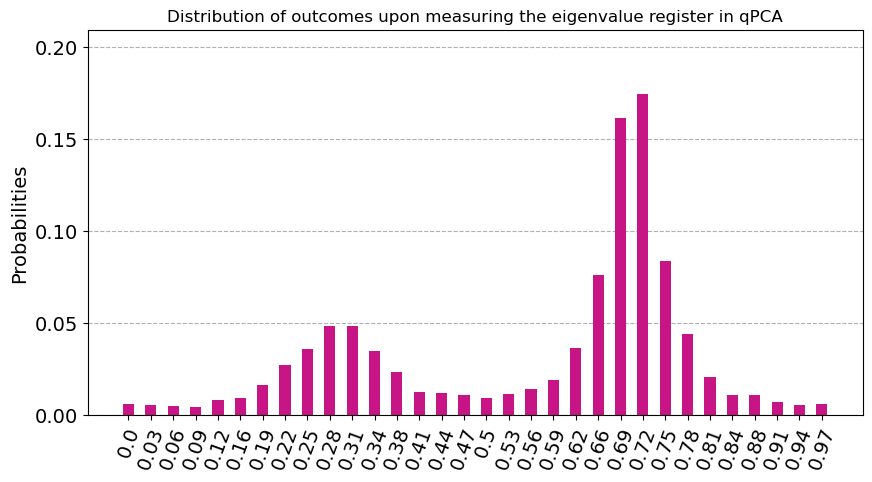

In [4367]:
qiskit.visualization.plot_histogram({round(int(k,2)/2**5,2):v for k,v in outcomes2.items()}, 
                                    title="Distribution of outcomes upon measuring the eigenvalue register in qPCA", bar_labels=False,color=['mediumvioletred'],
                                    figsize=(10,5))


In [4374]:
qiskit.visualization.plot_histogram({round(int(k,2)/2**5,2):v for k,v in outcomes.items()}, 
                                    title="Distribution of outcomes upon measuring the eigenvalue register in qPCA", bar_labels=False,color=['mediumvioletred'],
                                    figsize=(10,5))

plot_histogram([outcomes1_lol, outcomes2_lol],
               legend=['Simulator', 'Circuit decomposition'],
               bar_labels=False,
               title="Distribution of outcomes upon measuring the eigenvalue register in qPCA", 
               color=['slateblue', 'mediumvioletred'],
               figsize=(10,5))
plt.savefig("./test.png", bbox_inches="tight")

In [4341]:
# well partitioned
D = np.array([[0.68392582, 0.11945512],
       [0.03946855, 0.90996401],
       [0.80280525, 0.216806  ]])

In [4342]:
D.shape

(3, 2)

In [ ]:
from qiskit.quantum_info import Statevector 

In [3869]:
Statevector.from_int(round((2**5)*(evals[0])), 2**5).to_operator()

Operator([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2))

## Extracting Eigenvectors given Eigenvalue

[0.1982688 0.8017312]
0.8125


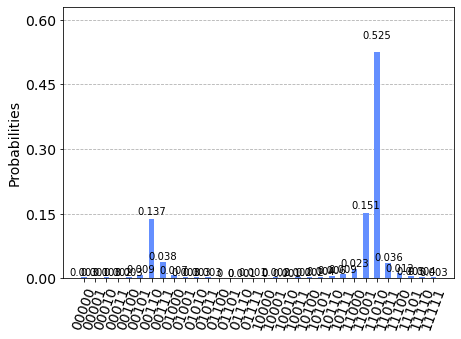

In [3958]:
m = 3
D = np.random.rand(m,2)

# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in D])
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = (1/m)*(np.matmul(X,X.T))
rho = DensityMatrix(Q)
cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 

evals, evecs = np.linalg.eig(Q)

evaldp = 5
eval_reg = QuantumRegister(evaldp, 'eval')
rho_reg = QuantumRegister(1, 'rho')
anc_reg = QuantumRegister(2, 'ancilla')

# 1/3 of QPE: Initialisation and Hadamards 
main_1 = QuantumCircuit(eval_reg, rho_reg)
main_1.h(range(0,evaldp));

#sigma = DensityMatrix(np.outer(evecs[:,1], evecs[:,1].conj()))
sigma = rho
rho2 = sigma ^ DensityMatrix(np.diag([1]+[0]*(2**eval_reg.size-1)))
rho2 = rho2.evolve(Operator(main_1))

# 2/3 of QPE: Controlled e^i\rho t via m*N partial swaps
#Hardcoded approach (faster and more accurate for evading partial swap requirement) 

N = 100
rep = 0
for counting_qubit in range(eval_reg.size):
    main_2 = QuantumCircuit(eval_reg, rho_reg , anc_reg)
    
    
    #main_2 = main_2.compose(exp_rho(2*np.pi).to_instruction(), [counting_qubit ,4]); # This is CU
    main_2 = main_2.compose(exp_rho(-2**rep*2*np.pi,Q).to_instruction(), [counting_qubit ,eval_reg.size])
    #main_2.cp(math.pi/4, counting_qubit, 4);
    rep +=1
    
    rho2 = partial_trace((DensityMatrix(np.diag([1,0])) ^ rho ^ rho2).evolve(Operator(main_2)), list(range(eval_reg.size+1,main_2.num_qubits)))

# 3/3 of QPE: Inverse qft
main_3 = QuantumCircuit(eval_reg, rho_reg)

qft_dagger(main_3, eval_reg.size)
rho2 = rho2.evolve(Operator(main_3))

# Measure eigenvalue register and output most probable value
outcomes = partial_trace(rho2, [eval_reg.size]).sample_counts(shots=10000)

print(evals.real)
print(int(max(outcomes, key=outcomes.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

qiskit.visualization.plot_histogram(outcomes)

In [3961]:
bin(round((2**5)*(evals[1])))[2:].zfill(evaldp)

'11010'

In [3987]:
outcome = rho2.measure(range(0, eval_reg.size))

In [3988]:
outcome

('00110',
 DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                ...,
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
               dims=(2, 2, 2, 2, 2, 2)))

In [3993]:
printmat(partial_trace(outcome[1], range(0, eval_reg.size)))

<IPython.core.display.Latex object>

In [3994]:
printmat(DensityMatrix(np.outer(evecs[:,0], evecs[:,0].conj())))

<IPython.core.display.Latex object>

In [3998]:
evec_heur = partial_trace(outcome[1], range(0, eval_reg.size)).data

In [4001]:
cols[0]

DensityMatrix([[0.84798225+0.j, 0.35903809+0.j],
               [0.35903809+0.j, 0.15201775+0.j]],
              dims=(2,))


In [4005]:
np.sqrt(np.trace(np.matmul(evec_heur.data, cols[0].data)).real)

0.4128834181703201

## SKlearn

In [5]:
import setup
from circuits import * 
from sklearn.datasets import load_digits
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA

<Figure size 432x288 with 0 Axes>

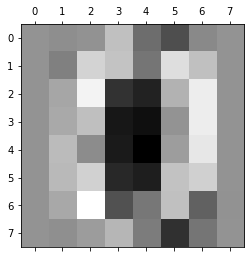

In [6]:
N = 100
d = 64
digits, _ = load_digits(return_X_y=True)
digits_trunc = digits[:N]
X = digits_trunc

X = X[:,:d]

X = X[~np.all(X == 0, axis=1)]
m = X.shape[0]

scaler = preprocessing.StandardScaler(with_std=False).fit(X)
X = scaler.transform(X)

plt.gray()

plt.matshow(X[0].reshape(int(np.sqrt(d)), int(np.sqrt(d))));

In [7]:
# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in X])
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = (1/m)*(np.matmul(X,X.T))
cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 
rho = DensityMatrix(Q)

evals, evecs = np.linalg.eig(Q)

evaldp = 6
eval_reg = QuantumRegister(evaldp, 'eval')
rho_reg = QuantumRegister(round(np.log2(d)), 'rho')

# 1/3 of QPE: Initialisation and Hadamards 
main_1 = QuantumCircuit(eval_reg, rho_reg)
main_1.h(range(0,evaldp));

#sigma = DensityMatrix(np.outer(evecs[:,1], evecs[:,1].conj())) # some evecs aren't valid?
sigma = rho
rho2 = sigma ^ DensityMatrix(np.diag([1]+[0]*(2**eval_reg.size-1)))
rho2 = rho2.evolve(Operator(main_1))

In [8]:
def exp_rho(x, Q):
    return Operator(Operator(MatrixOp(x*Q).exp_i()).to_instruction().control(1))

In [ ]:
# Use qiskit circuit

In [777]:
sigma.is_valid()

True

In [778]:
# 2/3 of QPE: Controlled e^i\rho t via m*N partial swaps
#Hardcoded approach (faster and more accurate for evading partial swap requirement) 

rep = 0
for counting_qubit in range(eval_reg.size):
    main_2 = QuantumCircuit(eval_reg, rho_reg)
    main_2 = main_2.compose(exp_rho(-2**rep*2*np.pi,Q).to_instruction(), [counting_qubit ,*rho_reg])
    rep +=1
    print(rho2.is_valid())
    rho2 = rho2.evolve(Operator(main_2))

True
True
True
True
True
True


In [779]:
# 3/3 of QPE: Inverse qft
main_3 = QuantumCircuit(eval_reg, rho_reg)

qft_dagger(main_3, eval_reg.size)
rho2 = rho2.evolve(Operator(main_3))

## Six qubit precision

[1.79618850e-01 1.59040937e-01 1.12909956e-01 9.69907156e-02
 8.64204149e-02 4.69703775e-02 4.37590682e-02 3.38599886e-02
 2.73360055e-02 2.61823090e-02 2.24566378e-02 1.82155343e-02
 1.51854026e-02 1.37179964e-02 1.17375545e-02 1.07014346e-02
 1.04365630e-02 8.96614817e-03 7.55738224e-03 7.51622757e-03
 6.47511036e-03 6.21961055e-03 5.23281828e-03 4.84341298e-03
 4.03908298e-03 3.69929430e-03 3.56274585e-03 3.22371400e-03
 2.94482648e-03 2.53654557e-03 2.13816630e-03 2.00402049e-03
 1.78497751e-03 1.55723833e-03 1.41980811e-03 1.38008084e-03
 1.21280064e-03 1.06160655e-03 9.82754109e-04 7.65372257e-04
 7.26509453e-04 6.08457668e-04 4.95632004e-04 4.24733899e-04
 3.29053226e-04 3.11977754e-04 2.19597590e-04 1.10595394e-04
 5.54467414e-05 4.87804823e-05 1.28817847e-06 2.42973587e-06
 2.00811381e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
0.15625


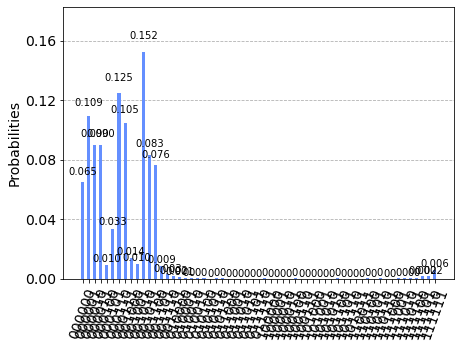

In [780]:
# Measure eigenvalue register and output most probable value
outcomes_6 = partial_trace(rho2, range(eval_reg.size, main_3.num_qubits)).sample_counts(shots=10000)

print(evals.real)
print(int(max(outcomes_6, key=outcomes_6.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

qiskit.visualization.plot_histogram(outcomes_6)

In [781]:
qargs =  range(0, eval_reg.size)

In [782]:
evecs_qpca = []

In [783]:
for i,eval in enumerate(evals):
    bin_eval = round((2** eval_reg.size)*(evals[i]))
    prob = rho2.probabilities(qargs)[bin_eval]
    proj = 1/np.sqrt(prob)*DensityMatrix(rho2).from_int(bin_eval, 2**(eval_reg.size)).to_operator()
    evec_qpca = partial_trace(rho2.evolve(proj, qargs), qargs)
    evecs_qpca.append(evec_qpca)
    print(bin_eval, np.max(evec_qpca.data - np.outer(evecs[:,i], evecs[:,i].conj())))

11 (0.011360188484814196+3.842965865632953e-13j)
10 (0.006588398348113783-8.029037958752394e-14j)
7 (0.010938643811358416-5.144600877346102e-13j)
6 (0.05615127844846381+1.0070170352455262e-13j)
6 (0.10608704651844472-2.932987667156457e-14j)
3 (0.058526749585997385+1.2898228310673613e-13j)
3 (0.07346845415823182-2.732168697288591e-13j)
2 (0.08489035408079076+6.092141548537698e-14j)
2 (0.1038652915865913+5.941841796803218e-14j)
2 (0.08220208062828915+3.6100054774398215e-14j)
1 (0.05048787033900679+4.202857272633659e-15j)
1 (0.10912969170599122+4.209558744815359e-14j)
1 (0.07162213057247489+9.68563395806846e-15j)
1 (0.11051414177863107-4.678054022031704e-14j)
1 (0.09942076965225562+1.1608711371308718e-16j)
1 (0.10898243341778208+2.842208534345184e-14j)
1 (0.11000123046970421+1.0896082837480574e-13j)
1 (0.10746877872115254+3.584504483529006e-14j)
0 (0.12271191063911573+2.6447037902087475e-14j)
0 (0.07899595656335408+5.148730018641138e-14j)
0 (0.107877754515563+1.523630973083102e-14j)
0 (0.

In [784]:
i = 0

In [785]:
printmat(evecs_qpca[i])

<IPython.core.display.Latex object>

In [786]:
printmat(DensityMatrix(np.outer(evecs[:,i], evecs[:,i].conj())))

<IPython.core.display.Latex object>

In [790]:
comps = 64
Z = []
for col in cols:
    z_i = []
    for i,evec_qpca in enumerate(evecs_qpca):
        if(i>=comps):
            break
        z_i.append(np.sqrt(np.trace(np.matmul(evec_qpca.data, col.data)).real))
    Z.append(z_i)

Z = np.array(Z)

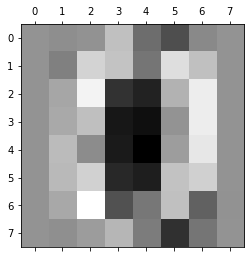

In [791]:
plt.matshow(X.T[0].reshape(8, 8));

<Figure size 432x288 with 0 Axes>

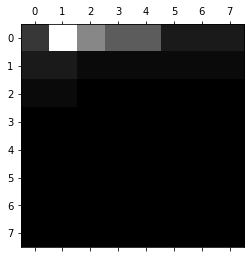

In [792]:
plt.gray()
plt.matshow(Z[0].reshape(8, 8));

In [793]:
evecs_qpca[0].data.shape

(64, 64)

In [794]:
basis = [DensityMatrix(np.outer(x,x)) for x in np.eye(64)]

In [795]:
evecs_pure = []
for i,evec_qpca in enumerate(evecs_qpca):
    evec_pure = []
    for base in basis:
        evec_pure.append(np.sqrt(np.trace(np.matmul(evec_qpca.data, base.data)).real))
    evecs_pure.append(evec_pure)

evecs_pure = np.array(evecs_pure)

In [796]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca.fit(X.T)

PCA(n_components=64)

<Figure size 576x576 with 0 Axes>

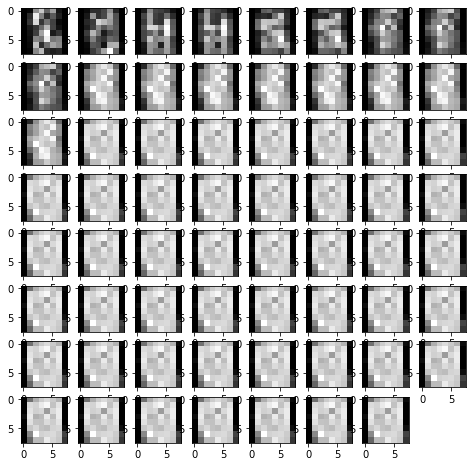

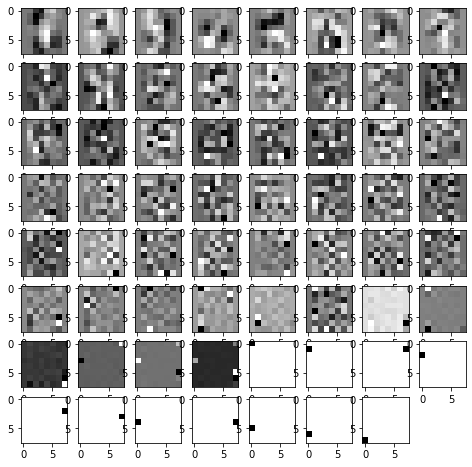

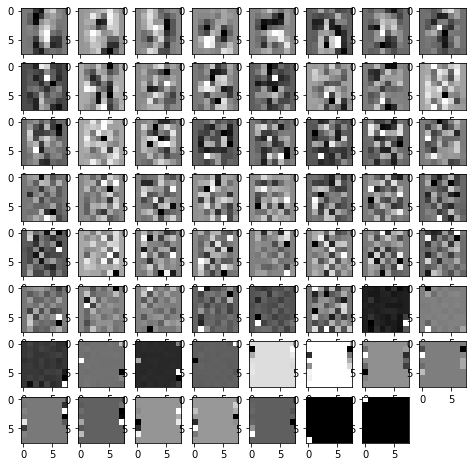

In [797]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for dataset in (evecs_pure, 
                np.repeat(np.array([np.max(evecs.T,axis=1)]), 64, axis=1).reshape(64,64)-evecs.T, 
                pca.components_):
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 8
    rows = 8
    for i in range(1, columns*rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow((dataset[i]).reshape(8,8))
    plt.show()

### Five qubit precision

[1.79618850e-01 1.59040937e-01 1.12909956e-01 9.69907156e-02
 8.64204149e-02 4.69703775e-02 4.37590682e-02 3.38599886e-02
 2.73360055e-02 2.61823090e-02 2.24566378e-02 1.82155343e-02
 1.51854026e-02 1.37179964e-02 1.17375545e-02 1.07014346e-02
 1.04365630e-02 8.96614817e-03 7.55738224e-03 7.51622757e-03
 6.47511036e-03 6.21961055e-03 5.23281828e-03 4.84341298e-03
 4.03908298e-03 3.69929430e-03 3.56274585e-03 3.22371400e-03
 2.94482648e-03 2.53654557e-03 2.13816630e-03 2.00402049e-03
 1.78497751e-03 1.55723833e-03 1.41980811e-03 1.38008084e-03
 1.21280064e-03 1.06160655e-03 9.82754109e-04 7.65372257e-04
 7.26509453e-04 6.08457668e-04 4.95632004e-04 4.24733899e-04
 3.29053226e-04 3.11977754e-04 2.19597590e-04 1.10595394e-04
 5.54467414e-05 4.87804823e-05 1.28817847e-06 2.42973587e-06
 2.00811381e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
0.09375


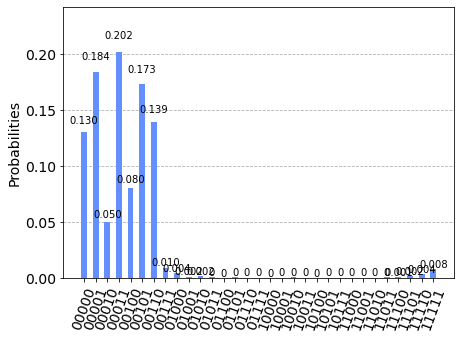

In [626]:
# Measure eigenvalue register and output most probable value
outcomes = partial_trace(rho2, range(eval_reg.size, main_3.num_qubits)).sample_counts(shots=10000)

print(evals.real)
print(int(max(outcomes, key=outcomes.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

qiskit.visualization.plot_histogram(outcomes)

[3.14001002e-01 2.81890744e-01 1.05680796e-01 8.76432013e-02
 7.43775948e-02 4.39158070e-02 3.42820076e-02 2.55640352e-02
 1.55230207e-02 1.03420581e-02 5.01175243e-03 1.75668276e-03
 1.12967786e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
0.3125


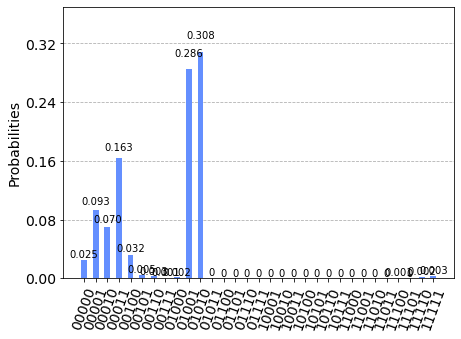

In [518]:
# Measure eigenvalue register and output most probable value
outcomes = partial_trace(rho2, range(eval_reg.size, main_3.num_qubits)).sample_counts(shots=10000)

print(evals.real)
print(int(max(outcomes, key=outcomes.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

qiskit.visualization.plot_histogram(outcomes)

In [630]:
qargs =  range(0, eval_reg.size)

In [631]:
evecs_qpca = []

In [632]:
for i,eval in enumerate(evals):
    bin_eval = round((2**5)*(evals[i]))
    prob = rho2.probabilities(qargs)[bin_eval]
    proj = 1/np.sqrt(prob)*DensityMatrix(rho2).from_int(bin_eval, 2**(eval_reg.size)).to_operator()
    evec_qpca = partial_trace(rho2.evolve(proj, qargs), qargs)
    evecs_qpca.append(evec_qpca)
    print(bin_eval, np.max(evec_qpca.data - np.outer(evecs[:,i], evecs[:,i].conj())))

6 (0.003245480514543292-4.2009191796649395e-14j)
5 (0.013410340780709809-7.10910479809154e-14j)
4 (0.012418456806763518+1.2787388359716937e-13j)
3 (0.07018865930823867+4.110286958565488e-14j)
3 (0.09173035611583727+1.4222297219751333e-14j)
2 (0.0716772576772858+1.007502212201537e-13j)
1 (0.08341856529201716+1.774200777166675e-14j)
1 (0.09395018390675502+2.8965619745701696e-14j)
1 (0.12051631021171154+2.1471666288367005e-14j)
1 (0.08574554413600997+1.531181561884649e-14j)
1 (0.05631591354060558+1.5780446244051872e-14j)
1 (0.12109183579658717+1.5173460547347115e-14j)
0 (0.07665537155023158+1.7844740169942814e-14j)
0 (0.10763910475288553+4.383012156579141e-14j)
0 (0.10318857220645863+1.6697470519184042e-14j)
0 (0.11299043452623948+2.2043332118789493e-14j)
0 (0.10208412029480057+1.1024266177520224e-14j)
0 (0.10807367753912886-3.3739451650373314e-14j)
0 (0.12177506884035408+1.8791837971356137e-14j)
0 (0.07838658340231375+2.6292632651225374e-14j)
0 (0.10529325318463988-4.7059882293027696e-14

In [634]:
i = 0

In [635]:
printmat(evecs_qpca[i])

<IPython.core.display.Latex object>

In [636]:
printmat(DensityMatrix(np.outer(evecs[:,i], evecs[:,i].conj())))

<IPython.core.display.Latex object>

In [645]:
comps = 4
Z = []
for col in cols:
    z_i = []
    for i,evec_qpca in enumerate(evecs_qpca):
        if(i>=comps):
            break
        z_i.append(np.sqrt(np.trace(np.matmul(evec_qpca.data, col.data)).real))
    Z.append(z_i)

Z = np.array(Z)

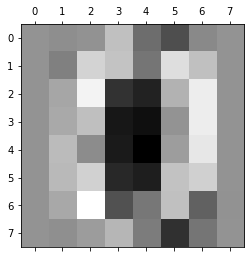

In [651]:
plt.matshow(X.T[0].reshape(8, 8));

<Figure size 432x288 with 0 Axes>

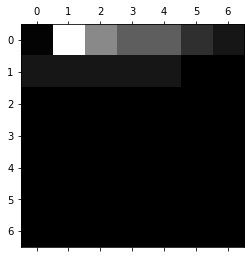

In [644]:
plt.gray()
plt.matshow(Z[0].reshape(7, 7));

In [656]:
evecs_qpca[0].data.shape

(64, 64)

In [657]:
basis = [DensityMatrix(np.outer(x,x)) for x in np.eye(64)]

In [769]:
evecs_pure = []
for i,evec_qpca in enumerate(evecs_qpca):
    evec_pure = []
    for base in basis:
        evec_pure.append(np.sqrt(np.trace(np.matmul(evec_qpca.data, base.data)).real))
    evecs_pure.append(evec_pure)

evecs_pure = np.array(evecs_pure)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca.fit(X.T)

<Figure size 576x576 with 0 Axes>

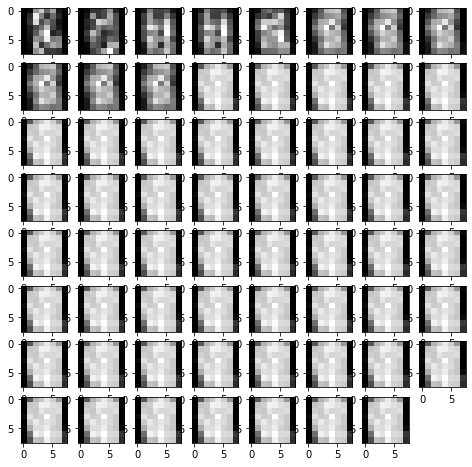

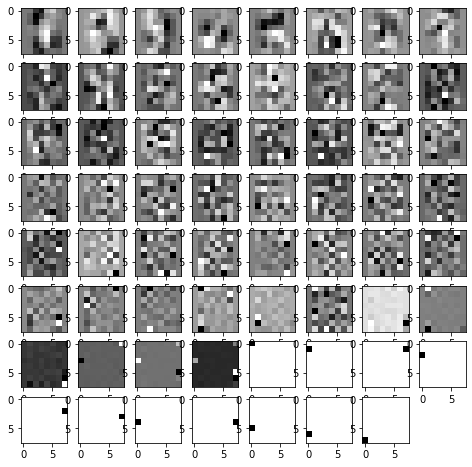

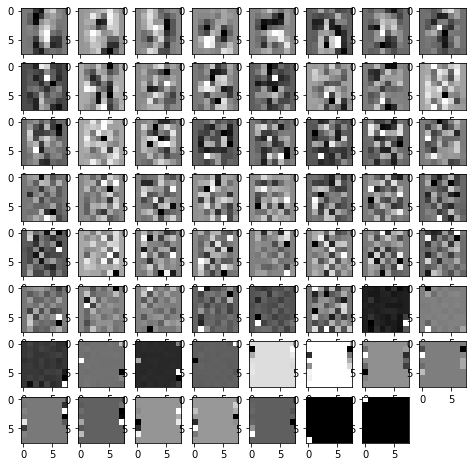

In [767]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for dataset in (evecs_pure, 
                np.repeat(np.array([np.max(evecs.T,axis=1)]), 64, axis=1).reshape(64,64)-evecs.T, 
                pca.components_):
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 8
    rows = 8
    for i in range(1, columns*rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow((dataset[i]).reshape(8,8))
    plt.show()

## MNIST

In [6]:
from sklearn import preprocessing

import tensorflow as tf

In [421]:
m = 100
d = 16

(60000, 4, 4, 1)


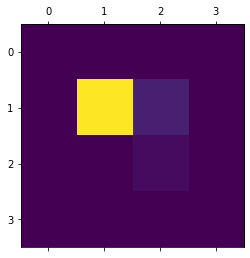

In [422]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)

# it's always better to normalize 
# x_train = x_train.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [int(np.sqrt(d)),int(np.sqrt(d))]) # if we want to resize 

print(x_train.shape)

plt.matshow(x_train[1])

In [423]:
X = tf.squeeze(x_train).numpy().reshape(60000,d)[:m]

In [424]:
X[~np.all(X == 0, axis=1)].shape

(93, 16)

In [425]:
X = X[~np.all(X == 0, axis=1)]
m = X.shape[1]

In [426]:
scaler = preprocessing.StandardScaler(with_std=False).fit(X)
X = scaler.transform(X)

In [420]:
# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in X])
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = (1/m)*(np.matmul(X,X.T))
#cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 

# Your initial 100 x 100 matrix 
a = np.zeros((2**round(np.log2(d)+1), 2**round(np.log2(d)+1)))


r=0
c=0
a[r:r+Q.shape[0], c:c+Q.shape[1]] += Q
Q = a

rho = DensityMatrix(Q)

In [386]:
evals, evecs = np.linalg.eig(Q)

evaldp = 5
eval_reg = QuantumRegister(evaldp, 'eval')
rho_reg = QuantumRegister(round(np.log2(d)), 'rho')

# 1/3 of QPE: Initialisation and Hadamards 
main_1 = QuantumCircuit(eval_reg, rho_reg)
main_1.h(range(0,evaldp));

#sigma = DensityMatrix(np.outer(evecs[:,1], evecs[:,1].conj())) # some evecs aren't valid?
sigma = rho
rho2 = sigma ^ DensityMatrix(np.diag([1]+[0]*(2**eval_reg.size-1)))
rho2 = rho2.evolve(Operator(main_1))

In [387]:
sigma.is_valid()

True

In [388]:
# 2/3 of QPE: Controlled e^i\rho t via m*N partial swaps
#Hardcoded approach (faster and more accurate for evading partial swap requirement) 

rep = 0
for counting_qubit in range(eval_reg.size):
    main_2 = QuantumCircuit(eval_reg, rho_reg)
    main_2 = main_2.compose(exp_rho(-2**rep*2*np.pi,Q).to_instruction(), [counting_qubit ,*rho_reg])
    rep +=1
    print(rho2.is_valid())
    rho2 = rho2.evolve(Operator(main_2))

KeyboardInterrupt: 

In [305]:
# 3/3 of QPE: Inverse qft
main_3 = QuantumCircuit(eval_reg, rho_reg)

qft_dagger(main_3, eval_reg.size)
rho2 = rho2.evolve(Operator(main_3))

np.sum(list(partial_trace(rho2, range(eval_reg.size, main_3.num_qubits)).probabilities_dict().values()))

# Measure eigenvalue register and output most probable value
outcomes = partial_trace(rho2, range(eval_reg.size, main_3.num_qubits)).sample_counts(shots=10000)

print(evals.real)
print(int(max(outcomes, key=outcomes.get), 2)/(2**eval_reg.size)) # Important: binary to float via b/2^n

qiskit.visualization.plot_histogram(outcomes)

## Exact QPE

In [ ]:
rho = DensityMatrix(np.diag([1]+[0]*(2**4-1)))

In [ ]:
qpe = QuantumCircuit(4)

In [1640]:
#qpe.x(3)
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘
q_3: ─────

In [1641]:
rho2 = rho.evolve(Operator(qpe))

In [1642]:

rep = 1
for counting_qubit in range(3):
    qpe = QuantumCircuit(4)
    
    for i in range(rep):
        qpe.cp(math.pi/4, counting_qubit, 3); # This is CU
    rep *= 2
    
    rho2 = rho2.evolve(Operator(qpe))
    
qpe.draw()



q_0: ────────────────────────────────────
                                         
q_1: ────────────────────────────────────
                                         
q_2: ─■────────■────────■────────■───────
      │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ─■────────■────────■────────■───────

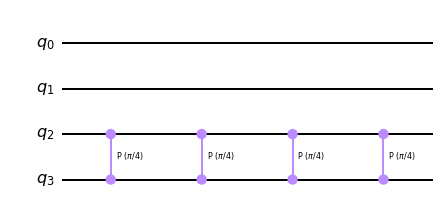

In [1643]:
qpe.draw('mpl')

In [1644]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [1645]:
qpe = QuantumCircuit(4)

In [1646]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()

In [1647]:
rho4 = rho2.evolve(Operator(qpe))

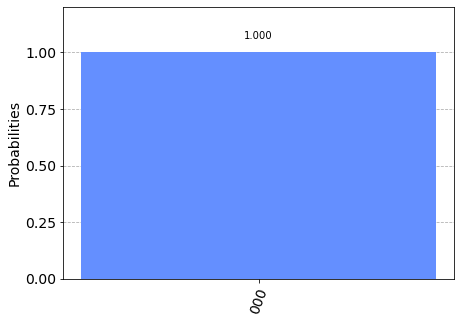

In [1648]:
qiskit.visualization.plot_histogram(partial_trace(rho4, [3]).sample_counts(shots=10000))

# Validating circuit implementation of $e^{-iSt}$

## Initialisation

In [ ]:
# X \in R^3x2, 4-D data arranged rowwise 
D = np.array([[0.32241437, 0.04200095],
       [0.32591982, 0.04014517],
       [0.17208166, 0.61868603]])
# Normalise each entry 
X = np.array([x / np.linalg.norm(x) for x in D])

# Columns
X = X.T

# Inner product between pairs of features; equivalent to |psi_i><psi_i| per i number of features
Q = 1/3*np.matmul(X,X.T)
rho = DensityMatrix(Q)

In [ ]:
evals, evecs = np.linalg.eig(rho.data)

sigma = DensityMatrix(np.outer(evecs[1], evecs[1]))

cols = [DensityMatrix(np.outer(x,x)) for x in X.T] 


In [ ]:
t = 1
N = 100
dt = 1/N

In [ ]:
w = Parameter("w")

In [ ]:
zero = DensityMatrix(np.diag([1,0]))

In [2429]:
rando = random_density_matrix(2)

## Main

In [2460]:
def es2_num(x):
    return Operator(MatrixOp(x*Operator(qc_swap2())).exp_i())

In [2462]:
def c_es2_num(x):
    return Operator(es2_num(x).to_instruction().control(1))

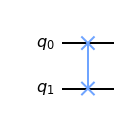

In [ ]:
qc_swap2().draw('mpl')

In [2445]:
rho_i = zero ^ rho ^ sigma ^ rando

In [2446]:
printmat(partial_trace((zero ^ rho ^ sigma ^ rando).evolve(c_es2(t)),[3]))

<IPython.core.display.Latex object>

In [2466]:
printmat((rho ^ sigma ^ rando).evolve(c_es2_num(t)))

<IPython.core.display.Latex object>

In [2472]:
printmat((rho ^ sigma ^ rando).evolve(c_es2_num(t)).data - partial_trace((zero ^ rho ^ sigma ^ rando).evolve(c_es2(t)),[3]).data)

<IPython.core.display.Latex object>

In [ ]:
# Indeed, tr(c_es2,[3]) = c_es2_num